## Task 2

In [14]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
!pip install tflearn

In [18]:
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')


In [19]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [20]:
sdr_df[sdr_df.split == "TRAIN"].shape

(2000, 5)

In [21]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]


In [22]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

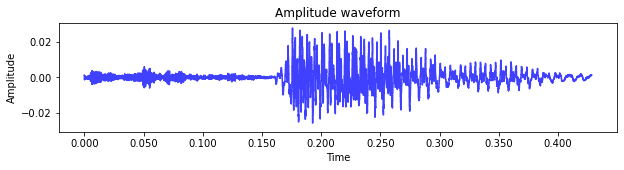

In [23]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [24]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [25]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

melspectrogram.shape
# x.shape

(13, 43)

In [26]:
import os
import time
import random
import tflearn
import librosa
import numpy as np
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [27]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')



train_data = data[data.split =="TRAIN"]
dev_data = data[data.split =="DEV"]
test_data = data[data.split =="TEST"]


## Preprocessing of Data

In [28]:
def get_nn_data(df):
    signals = df.file.values
    labels = df.label.values
    # This value details is given in TASK 1 parameter N <= 25
    # N=10   

    signals1 = []
    for file in df.file.values:
        signal1, sr = librosa.load(file)
        signals1.append(signal1)

    return [extract_melspectrogram(s, sr=8000, num_mels=13) for s in signals1], labels

In [29]:
nn_train, train_labels = get_nn_data(train_data)
print(nn_train[2])

[[-2.2741847  -1.3208863  -1.4830146  ... -0.81838155 -0.9981574
  -1.4287398 ]
 [-1.0942035  -0.39628923 -0.7949283  ... -0.64620376 -0.7473365
  -0.94756997]
 [-0.5984957  -0.17020981  0.34357923 ...  0.15686874  0.09897813
  -0.23630676]
 ...
 [ 3.6494758   2.3761845  -0.41912842 ... -0.45667458  0.17729683
   1.9654638 ]
 [ 3.8775768   2.616933   -0.42861995 ... -0.52657515  0.47307432
   2.2103999 ]
 [ 4.0930676   2.8280146  -0.4012446  ... -0.52157     0.76714927
   2.4917164 ]]


In [30]:
print(nn_train[2])

[[-2.2741847  -1.3208863  -1.4830146  ... -0.81838155 -0.9981574
  -1.4287398 ]
 [-1.0942035  -0.39628923 -0.7949283  ... -0.64620376 -0.7473365
  -0.94756997]
 [-0.5984957  -0.17020981  0.34357923 ...  0.15686874  0.09897813
  -0.23630676]
 ...
 [ 3.6494758   2.3761845  -0.41912842 ... -0.45667458  0.17729683
   1.9654638 ]
 [ 3.8775768   2.616933   -0.42861995 ... -0.52657515  0.47307432
   2.2103999 ]
 [ 4.0930676   2.8280146  -0.4012446  ... -0.52157     0.76714927
   2.4917164 ]]


In [31]:


num_classes = 10
array=train_labels
array=np.array(train_labels)
labels = torch.from_numpy(train_labels)
labels = F.one_hot(labels, num_classes)
labels = labels.type("torch.FloatTensor")


max_len = 130

rnn_train_data = []
for sublist in nn_train:
    x = sublist.shape
#     print("x1", x[1])
#     print("max_len-x1", max_len-x[1])
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_train_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))



In [32]:
rnn_train_data = torch.stack(rnn_train_data)

In [33]:
# rnn_train_data = torch.tensor(rnn_train_data)
rnn_train_data.shape
labels.type

<function Tensor.type>

## Data Loader for Training

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNNTrainDataset(Dataset):
    def __init__(self, rnn_train_data, labels):
        self.rnn_train_data = rnn_train_data
        self.labels = labels

    def __len__(self):
        return len(self.rnn_train_data)

    def __getitem__(self, idx):
        return self.rnn_train_data[idx], self.labels[idx]

batch_size = 20

train_dataset = RNNTrainDataset(rnn_train_data, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [35]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

Batch 0:
Data: torch.Size([20, 130, 13]), -4.190584182739258, 7.196196556091309
Target: torch.Size([20, 10])
Batch 1:
Data: torch.Size([20, 130, 13]), -4.218393325805664, 6.029603958129883
Target: torch.Size([20, 10])
Batch 2:
Data: torch.Size([20, 130, 13]), -4.27483606338501, 6.438503742218018
Target: torch.Size([20, 10])
Batch 3:
Data: torch.Size([20, 130, 13]), -3.718120574951172, 6.305238723754883
Target: torch.Size([20, 10])
Batch 4:
Data: torch.Size([20, 130, 13]), -4.143735885620117, 6.898062229156494
Target: torch.Size([20, 10])
Batch 5:
Data: torch.Size([20, 130, 13]), -4.593776702880859, 5.780646324157715
Target: torch.Size([20, 10])
Batch 6:
Data: torch.Size([20, 130, 13]), -4.559310436248779, 6.084070205688477
Target: torch.Size([20, 10])
Batch 7:
Data: torch.Size([20, 130, 13]), -3.9744558334350586, 6.0421624183654785
Target: torch.Size([20, 10])
Batch 8:
Data: torch.Size([20, 130, 13]), -5.587302207946777, 6.433138847351074
Target: torch.Size([20, 10])
Batch 9:
Data: tor

## Hyperparameters

In [36]:
# hp
num_epochs=100
input_size = 13
hidden_size = 128
num_classes = 10
learning_rate = 0.01
n_total_steps = len(rnn_train_data)
# num_layers=3






## LSTM model

In [37]:
class RNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size
        #self.rnn = nn.RNN(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True) #if we want to run LSTM then we need to uncoment this line,and comnt abve line
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        c0 = torch.zeros(2, 20, self.hidden_size, dtype=torch.float32)
        # out : seq_len x hidden_size
        #out, _ = self.rnn(x, h0)
        out, _ = self.lstm(x, (h0, c0))     #if we want to run LSTM then we need to uncoment this line, and coment above line
        out = self.fc(out[:, -1, :])
        out_softmax = F.softmax(out)
        return out, out_softmax

## Training loop that also plot loss graph and tsne plot for last out layer

In [ ]:
import matplotlib.pyplot as plt
rnn3 = RNN1(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn3.parameters(), lr=learning_rate)

# initialize an empty list to store the loss at each epoch
loss_history = []
features = []
labels = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for i, (sample, label) in enumerate(train_loader):
        # Forward pass
        last_layer, out = rnn3(sample)
        features.append(last_layer.detach().cpu().numpy())
        labels.append(label.cpu().numpy())
        loss = criterion(out, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples += len(label)

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    loss_history.append(train_loss)  # append the loss at this epoch to the list
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
    
    
# plot the loss history
plt.plot(loss_history)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('Training_Loss.png')



# # # Tsne Plot
# from sklearn.manifold import TSNE
# features = np.concatenate(features, axis=0)
# labels = np.concatenate(labels, axis=0)

# tsne = TSNE(n_components=2, random_state=42)
# embedded_features = tsne.fit_transform(features)

# # plot the embedded features with different colors for different labels
# fig, ax = plt.subplots(figsize=(12, 6))

# plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
# plt.colorbar()
# plt.show()


Epoch [1/100], Step [100/100], Loss: 2.4111
Train loss: 2.3468, Train accuracy: 0.1055
Epoch [2/100], Step [100/100], Loss: 2.3611
Train loss: 2.3611, Train accuracy: 0.1000


In [ ]:
### for color TSNE plot
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

rnn3 = RNN1(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn3.parameters(), lr=learning_rate)

# initialize an empty list to store the loss at each epoch
loss_history = []
features = []
labels = []

for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for i, (sample, label) in enumerate(train_loader):
        # Forward pass
        last_layer, out = rnn3(sample)
        features.append(last_layer.detach().cpu().numpy())
        labels.append(label.cpu().numpy())
        loss = criterion(out, label)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples += len(label)

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    loss_history.append(train_loss)  # append the loss at this epoch to the list
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
    
# plot the loss history
plt.plot(loss_history)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plt.savefig('Training_Loss.png')

# TSNE plot
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# plot the embedded features with different colors for different labels
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(num_classes):
    # plot the points with label i in color i
    plt.scatter(embedded_features[labels==i, 0], embedded_features[labels==i, 1], label=f'Class {i}')
    
plt.legend()
plt.show()


In [ ]:
features

## for saving the model

In [ ]:
# torch.save(rnn3.state_dict(), 'LSTM_model_with_40%_t_ACC.pth')

## Dev Accuracy

In [ ]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')



train_data = data[data.split =="TRAIN"]
dev_data = data[data.split =="DEV"]
test_data = data[data.split =="TEST"]

In [ ]:
dev_data = data[data.split =="DEV"]
dev_data_eval, dev_labels =get_nn_data(train_data)

# nn_train, train_labels = get_nn_data(train_data)

In [ ]:
num_classes = 10
array_dev=dev_labels
array_dev=np.array(dev_labels)
rnn_dev_labels = torch.from_numpy(dev_labels)
rnn_dev_labels = F.one_hot(rnn_dev_labels, num_classes)
rnn_dev_labels = rnn_dev_labels.type("torch.FloatTensor")
print(len(rnn_dev_labels))

max_len = 130

rnn_dev_data = []
for sublist in dev_data_eval:
    x = sublist.shape
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_dev_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))      



In [ ]:
rnn_dev_data = torch.stack(rnn_dev_data)
rnn_dev_data.shape

In [ ]:

batch_size = 20

dev_dataset = RNNTrainDataset(rnn_dev_data, rnn_dev_labels)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True )


In [ ]:
for batch_idx, (data, target) in enumerate(dev_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

## Calculating the Dev set accuracy

In [ ]:
from sklearn.manifold import TSNE
rnn_testing = RNN1(input_size, hidden_size, num_classes)
features = []
labels = []


with torch.no_grad():
    total_correct_dev = 0
    total_samples_dev = 0
    for i, (sample, label) in enumerate(dev_loader):
        last_layer, out = rnn3(sample)
        features.append(last_layer.cpu().numpy())
        labels.append(label.cpu().numpy())

        preds_dev = torch.argmax(out)
        labels_class_dev = torch.argmax(rnn_dev_labels[i])
        correct = (preds_dev == labels_class_dev)
        total_correct_dev += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples_dev += len(label)
        
    test_acc = total_correct_dev / total_samples_dev
    print(total_correct_dev)
    print(total_samples_dev)
    print(f'dev accuracy: {test_acc *100:.4f} %')
    
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# plot the embedded features with different colors for different labels
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
plt.colorbar()
plt.show()


In [ ]:
from sklearn.manifold import TSNE
rnn_testing = RNN1(input_size, hidden_size, num_classes)
features = []
labels = []


with torch.no_grad():
    total_correct_dev = 0
    total_samples_dev = 0
    for i, (sample, label) in enumerate(dev_loader):
        last_layer, out = rnn3(sample)
        features.append(last_layer.cpu().numpy())
        labels.append(label.cpu().numpy())

        preds_dev = torch.argmax(out)
        labels_class_dev = torch.argmax(rnn_dev_labels[i])
        correct = (preds_dev == labels_class_dev)
        total_correct_dev += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples_dev += len(label)
        
    test_acc = total_correct_dev / total_samples_dev
    print(total_correct_dev)
    print(total_samples_dev)
    print(f'dev accuracy: {test_acc *100:.4f} %')
    
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

plt.figure(figsize=(12, 8))
embedded_features = tsne.fit_transform(features)
labels = np.argmax(labels, axis=1)

# Reshape embedded_features to have a single dimension
embedded_features = embedded_features.reshape(-1)

# Create labels as a 1-dimensional array
labels = labels.ravel()
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
plt.scatter(embedded_features[::2], embedded_features[1::2], c=labels)
plt.colorbar()
plt.show()



### Confusion Matrix and Precision,Recall,F1-Score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

rnn_testing = RNN1(input_size, hidden_size, num_classes)

with torch.no_grad():
    total_correct_dev = 0
    total_samples_dev = 0
    all_preds = []
    all_labels = []
    for i, (sample, label) in enumerate(dev_loader):
        last_layer, out = rnn3(sample)

        preds_dev = torch.argmax(out, dim=1)
        labels_class_dev = torch.argmax(label, dim=1)
        
        all_preds.extend(preds_dev.cpu().numpy())
        all_labels.extend(labels_class_dev.cpu().numpy())
        
        total_correct_dev += torch.sum(preds_dev == labels_class_dev).item()
        total_samples_dev += len(label)
        
    dev_acc = total_correct_dev / total_samples_dev
    print(total_correct_dev)
    print(total_samples_dev)
    print(f'dev accuracy: {dev_acc *100:.4f} %')
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
#   print('Confusion matrix on Dev set:\n', cm)
    print('Confusion matrix on Dev set:\n')
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
cm = confusion_matrix(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average='macro')
overall_precision = precision_score(all_labels, all_preds, average='macro')
overall_recall = recall_score(all_labels, all_preds, average='macro')

print('Confusion matrix on Dev set:\n', cm)
print('Overall F1-score:', overall_f1)
print('Overall precision:', overall_precision)
print('Overall recall:', overall_recall)

    

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

cm = confusion_matrix(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average='macro')
overall_precision = precision_score(all_labels, all_preds, average='macro')
overall_recall = recall_score(all_labels, all_preds, average='macro')

print('Confusion matrix on Dev set:\n', cm)
print('Overall F1-score:', overall_f1)
print('Overall precision:', overall_precision)
print('Overall recall:', overall_recall)


# Test set Accuracy

In [ ]:
# prepare data and split 
from sklearn.model_selection import train_test_split

data = pd.read_csv('SDR_metadata.tsv', sep='\t')



train_data = data[data.split =="TRAIN"]
dev_data = data[data.split =="DEV"]
test_data = data[data.split =="TEST"]


In [ ]:
test_data = data[data.split =="TEST"]
test_data_eval, test_labels =get_nn_data(test_data)

In [ ]:
num_classes = 10
array_test=test_labels
array_test=np.array(test_labels)
rnn_test_labels = torch.from_numpy(test_labels)
rnn_test_labels = F.one_hot(rnn_test_labels, num_classes)
rnn_test_labels = rnn_test_labels.type("torch.FloatTensor")
print(len(rnn_test_labels))

max_len = 130

rnn_test_data = []
for sublist in test_data_eval:
    x = sublist.shape
    
   
    if x[1]> max_len:
        #truncating here
        padded_arr=sublist[:, :max_len]
    else:
        # for padding
        padded_arr = np.pad(sublist, pad_width=((0,0),(0,max_len-x[1])), mode='constant')    
    rnn_test_data.append(torch.transpose(torch.from_numpy(padded_arr), 0,1))

    

# rnn_train_data = torch.stack(rnn_train_data)
        

rnn_dev_data[0].shape

In [ ]:
rnn_test_data = torch.stack(rnn_test_data)

In [ ]:
rnn_test_data.shape

In [ ]:

batch_size = 20

test_dataset = RNNTrainDataset(rnn_test_data, rnn_test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True )

In [ ]:
for batch_idx, (data, target) in enumerate(test_loader):
    print(f"Batch {batch_idx}:")
    print(f"Data: {data.shape}, {data.min()}, {data.max()}")
    print(f"Target: {target.shape}")

In [ ]:
rnn_testing = RNN1(input_size, hidden_size, num_classes)
features = []
labels = []

with torch.no_grad():
    total_correct_test = 0
    total_samples_test = 0
    for i, (sample, label) in enumerate(test_loader):
        last_layer, out = rnn3(sample)
        features.append(last_layer.cpu().numpy())
        labels.append(label.cpu().numpy())
        preds_test = torch.argmax(out)
        labels_class_test = torch.argmax(rnn_test_labels[i])
        correct = (preds_test == labels_class_test)
        total_correct_test += torch.sum(torch.argmax(out, dim=1) == torch.argmax(label, dim=1)).item()
        total_samples_test += len(label)
        
    test_acc = total_correct_test / total_samples_test
    print(total_correct_test)
    print(total_samples_test)
    print(f'test accuracy: {test_acc *100:.4f} %')
    
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# plot the embedded features with different colors for different labels
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(embedded_features[:, 0], embedded_features[:, 1])
plt.title('TSNe for test Classification')
plt.colorbar()
plt.show()


## confusion matrix and classification report
## Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. (task 2.2)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

rnn_testing = RNN1(input_size, hidden_size, num_classes)

with torch.no_grad():
    total_correct_test = 0
    total_samples_test = 0
    all_preds = []
    all_labels = []
    for i, (sample, label) in enumerate(test_loader):
        last_layer, out = rnn3(sample)

        preds_test = torch.argmax(out, dim=1)
        labels_class_test = torch.argmax(label, dim=1)
        
        all_preds.extend(preds_test.cpu().numpy())
        all_labels.extend(labels_class_test.cpu().numpy())
        
        total_correct_test += torch.sum(preds_test == labels_class_test).item()
        total_samples_test += len(label)
        
    test_acc = total_correct_test / total_samples_test
    print(total_correct_test)
    print(total_samples_test)
    print(f'test accuracy: {test_acc *100:.4f} %')
    
    # Compute confusion matrix
    cm_test = confusion_matrix(all_labels, all_preds)
    print('Confusion matrix for test Set:\n')
    sns.heatmap(cm_test, annot=True, fmt='d')
    
cm = confusion_matrix(all_labels, all_preds)
overall_f1 = f1_score(all_labels, all_preds, average='macro')
overall_precision = precision_score(all_labels, all_preds, average='macro')
overall_recall = recall_score(all_labels, all_preds, average='macro')

print('Confusion matrix on Test set:\n', cm)
print('Overall F1-score:', overall_f1)
print('Overall precision:', overall_precision)
print('Overall recall:', overall_recall)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, rnn3.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

## Statistical test (p_value)------ (Bootstrapping)

In [ ]:
import torch.utils.data as data_utils

# convert test data to PyTorch tensors
test_data_eval_tensor =rnn_test_data
test_labels_tensor = rnn_test_labels

# create a WeightedRandomSampler with replacement
sampler = data_utils.WeightedRandomSampler(weights=torch.ones(len(test_data_eval_tensor)), num_samples=len(test_data_eval_tensor), replacement=True)

# create a DataLoader with the sampler
test_loader_bootstrap = data_utils.DataLoader(dataset=data_utils.TensorDataset(test_data_eval_tensor, test_labels_tensor), batch_size=batch_size, sampler=sampler,drop_last=True)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define the number of bootstrap samples
num_bootstraps = 1000
samp=0
# Create a list to store the accuracy values for each bootstrap sample
bootstrapped_accs = []

# Define the RNN model
rnn_testing = RNN1(input_size, hidden_size, num_classes)

# Iterate over the specified number of bootstrap samples
for i in range(num_bootstraps):
    # Create a new DataLoader object using a WeightedRandomSampler to sample with replacement from the test data
    sampler = torch.utils.data.WeightedRandomSampler(weights=torch.ones(len(test_data_eval_tensor)), num_samples=len(test_data_eval_tensor), replacement=True)
    test_loader_bootstrap = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(test_data_eval_tensor, test_labels_tensor), batch_size=batch_size, sampler=sampler, drop_last=True)
    samp++i
    with torch.no_grad():
        total_correct_test = 0
        total_samples_test = 0
        all_preds = []
        all_labels = []
        for i, (sample, label) in enumerate(test_loader_bootstrap):
            last_layer, out = rnn3(sample)

            preds_test = torch.argmax(out, dim=1)
            labels_class_test = torch.argmax(label, dim=1)

            all_preds.extend(preds_test.cpu().numpy())
            all_labels.extend(labels_class_test.cpu().numpy())

            total_correct_test += torch.sum(preds_test == labels_class_test).item()
            total_samples_test += len(label)
        test_acc = total_correct_test / total_samples_test
        bootstrapped_accs.append(test_acc)

# Compute the mean and standard deviation of the accuracy values across all bootstrap samples
mean_acc = sum(bootstrapped_accs) / num_bootstraps
std_acc = np.std(bootstrapped_accs)

print(f'Mean accuracy: {mean_acc * 100:.4f} %')
print(f'Standard deviation: {std_acc:.4f}')

# Compute confusion matrix
cm_test = confusion_matrix(all_labels, all_preds)
print('Confusion matrix for test Set:\n')
sns.heatmap(cm_test, annot=True, fmt='d')

# Compute precision, recall, F1-score
report = classification_report(all_labels, all_preds)
print('Classification report:\n', report)


## Significance Test (Task 2.4)

In [ ]:
import numpy as np

# Set up the data
rnn_mean_acc = 0.440736  # this value is calculated using bootstrap in Task no.2 
rnn_std_acc = 0.0219     # this value is calculated using bootstrap in Task no.1
linear_mean_acc = 0.0995924453280318
linear_std_acc = 0.023840615328288208

# Calculate the difference in mean accuracy between the two models
mean_diff = rnn_mean_acc - linear_mean_acc

# Concatenate the accuracy values for both models
combined_acc = np.concatenate((np.random.normal(rnn_mean_acc, rnn_std_acc, size=1000), 
                               np.random.normal(linear_mean_acc, linear_std_acc, size=1000)))

# Generate bootstrap samples and calculate mean accuracy differences
n_bootstrap = 1000
bootstrap_diff = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    resampled_acc = np.random.choice(combined_acc, size=len(combined_acc), replace=True)
    rnn_mean = np.mean(resampled_acc[:1000])
    linear_mean = np.mean(resampled_acc[1000:])
    bootstrap_diff[i] = rnn_mean - linear_mean

# Calculate the p-value
p_value = np.mean(bootstrap_diff >= mean_diff)

# Print the results
print("Mean difference between RNN and linear regression models: {:.4f}".format(mean_diff))
print("p-value: {:.4f}".format(p_value))
if p_value < 0.05:
    print("The difference between the mean accuracy of the RNN and linear regression models is statistically significant.")
else:
    print("There is no statistically significant difference between the mean accuracy of the RNN and linear regression models.")
